In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy
import gammapy
import logging
import os
import numpy as np
import astropy.units as u
from matplotlib.colors import LogNorm
from gammapy.extern import xmltodict
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion, PixCoord
from gammapy.utils.fitting import Fit
from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    models,
    FluxPointsEstimator,
    FluxPointsDataset,
)
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom
from gammapy.cube import MapMaker
from gammapy.background import ReflectedRegionsBackgroundEstimator, RingBackgroundEstimator
from gammapy.detect import TSMapEstimator, find_peaks
from gammapy.data import DataStore
from gammapy.spectrum.models import PowerLaw
print("numpy:", np.__version__)
print("astropy:", astropy.__version__)
print("gammapy:", gammapy.__version__)

numpy: 1.16.5
astropy: 3.1.2
gammapy: 0.13


In [3]:
SkyCoord.from_name("NGC253")

<SkyCoord (ICRS): (ra, dec) in deg
    (11.88805833, -25.2888)>

In [4]:
SkyCoord.from_name("Crab")

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>

In [5]:
from gammapy.data import EventList
path = "/home/rishank/Downloads/NGC253_events_z60.fits"
events = EventList.read(path)

In [6]:
events.table

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,631108923.6803265,11.9113865,-25.300419,0.10089185,0.39958122,0.010293951,1
2,631108933.4349213,12.023283,-25.309286,0.13215733,0.3906626,0.11145014,1
3,631108972.241843,12.0442295,-25.357737,0.117421396,0.3421926,0.13033406,1
4,631109164.4523504,11.790965,-25.265676,0.12957786,0.4342835,-0.09860576,1
5,631109175.2263246,11.858778,-25.240276,0.11214822,0.45971778,-0.037286468,1
6,631109267.6978309,11.62943,-25.240858,0.11779386,0.45889232,-0.24473953,1
7,631109366.080923,11.943797,-25.128902,0.13313988,0.57109076,0.039652735,1
8,631109371.7931418,11.899482,-25.263014,0.137936,0.43698645,-0.0004686401,1


In [7]:
# Configure the logger, so that the spectral analysis
# isn't so chatty about what it's doing.

logging.basicConfig()
log = logging.getLogger("gammapy.spectrum")
log.setLevel(logging.ERROR)


In [8]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [9]:
from pathlib import Path
path = Path("/home/rishank/Downloads/")
paths = list(path.rglob("NGC253*.fits"))
data_store = DataStore.from_events_files(paths)
observations = data_store.get_observations()
#from gammapy.data import DataStore
#path = "/home/rishank/M82_events.fits"
#data_store = DataStore.from_events_files([path])
#observations = data_store.get_observations()

In [10]:
data_store.obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,TELESCOP,CALDB,IRF,EVENTS_FILENAME,EVENT_COUNT
,deg,deg,deg,deg,deg,deg,deg,s,s,,s,s,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str13,str13,str13,str13,int64,str1,str3,str9,str13,str46,int64
1,11.9,-25.7,91.68395438950571,-88.33319184881798,0.0,90.0,0.0,259200.0,254016.0,0.98,631108869.18,631368069.18,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,0,,CTA,prod3b-v2,South_z60_50h,/home/rishank/Downloads/NGC253_events_z60.fits,4779344


In [11]:
is_gamma = events.table["MC_ID"] == 1
print("Number of events: ", len(events.table))
print("Number of gammas: ", is_gamma.sum())
print("Number of hadrons: ", len(events.table) - is_gamma.sum())

Number of events:  4779344
Number of gammas:  22451
Number of hadrons:  4756893


In [12]:
ra = events.table["RA"].data
dec = events.table["DEC"].data
print(ra.mean())
print(dec.mean())
gamma_ra = ra[is_gamma].mean()
print(gamma_ra)
gamma_dec = dec[is_gamma].mean()
print(gamma_dec)
d = SkyCoord(ra=gamma_ra*u.degree, dec=gamma_dec*u.degree, frame='icrs')
d.galactic

11.900566
-25.684002
11.8806305
-25.289965


<SkyCoord (Galactic): (l, b) in deg
    (97.17890676, -87.96273781)>

In [13]:
table = data_store.obs_table
c = SkyCoord(ra=table['RA_PNT'], dec=table['DEC_PNT'], frame='icrs')
c.galactic

<SkyCoord (Galactic): (l, b) in deg
    [(91.68395439, -88.33319185)]>

<SkyCoord (Galactic): (l, b) in deg
    (91.68395439, -88.33319185)>

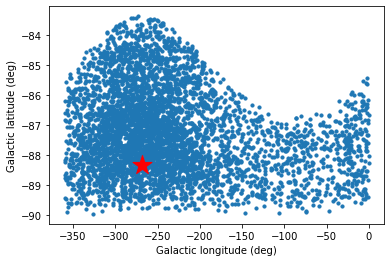

In [14]:
# Event positions
pos = events.galactic[::1000]  # sub-sample every 100th event
plt.scatter(pos.l.wrap_at("0 deg").deg, pos.b.deg, s=10)
# Pointing position
pos_pnt = events.pointing_radec.galactic
plt.scatter(
    pos_pnt.l.wrap_at("0 deg").deg, pos_pnt.b.deg, marker="*", s=400, c="red"
)
plt.xlabel("Galactic longitude (deg)")
plt.ylabel("Galactic latitude (deg)")
pos_pnt

<SkyCoord (Galactic): (l, b) in deg
    (91.68395439, -88.33319185)>

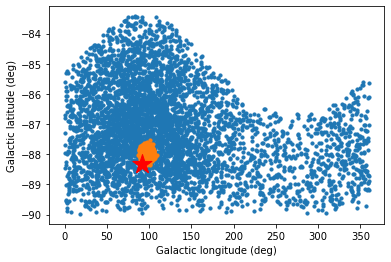

In [15]:
# Event positions
pos = events.galactic[~is_gamma][::1000]  # sub-sample every 100th event
plt.scatter(pos.l.wrap_at("360 deg").deg, pos.b.deg, s=10)
# Pointing position
pos_pnt = events.pointing_radec.galactic
plt.scatter(
    pos_pnt.l.wrap_at("360 deg").deg, pos_pnt.b.deg, marker="*", s=400, c="red"
)
plt.xlabel("Galactic longitude (deg)")
plt.ylabel("Galactic latitude (deg)")
pos_pnt


#Event positions
pos = events.galactic[is_gamma][::1]  # sub-sample every 100th event
plt.scatter(pos.l.wrap_at("360 deg").deg, pos.b.deg, s=10)
# Pointing position
pos_pnt = events.pointing_radec.galactic
plt.scatter(
    pos_pnt.l.wrap_at("360 deg").deg, pos_pnt.b.deg, marker="*", s=400, c="red"
)
plt.xlabel("Galactic longitude (deg)")
plt.ylabel("Galactic latitude (deg)")
pos_pnt

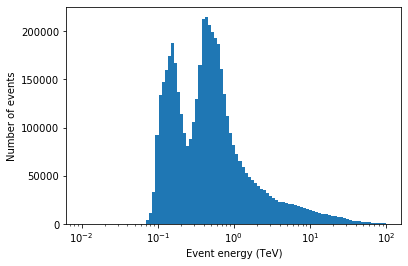

In [16]:
energy = events.table["ENERGY"].data
energy_bins = np.logspace(-2, 2, num=100)
plt.hist(energy, bins=energy_bins)
plt.semilogx()
plt.xlabel("Event energy (TeV)")
plt.ylabel("Number of events");

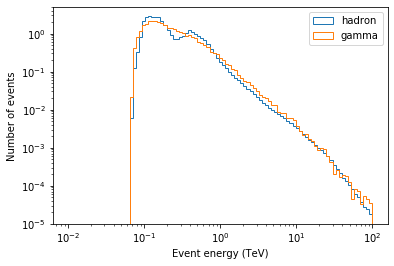

In [17]:
energy = events.table["ENERGY"].data
energy_bins = np.logspace(-2, 2, num=100)
opts = dict(bins=energy_bins, density=True, histtype="step")
plt.hist(energy[~is_gamma], label="hadron", **opts)
plt.hist(energy[is_gamma], label="gamma", **opts)
plt.loglog()
plt.xlabel("Event energy (TeV)")
plt.ylabel("Number of events")
plt.legend();

Text(0, 0.5, 'Offset (deg)')

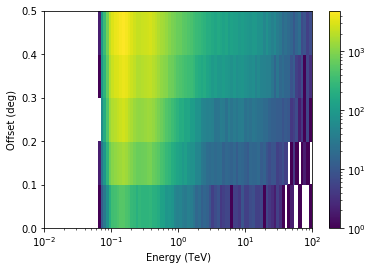

In [18]:

energy_bins = 10 ** np.linspace(-2, 2, 100)
offset_bins = np.arange(0, 0.6, 0.1)

t = events.table
offset = np.sqrt(t["DETX"] ** 2 + t["DETY"] ** 2)
hist = np.histogram2d(
    x=t["ENERGY"], y=offset, bins=(energy_bins, offset_bins)
)[0].T

plt.pcolormesh(energy_bins, offset_bins, hist, norm=LogNorm())
plt.semilogx()
plt.colorbar()
plt.xlabel("Energy (TeV)")
plt.ylabel("Offset (deg)")

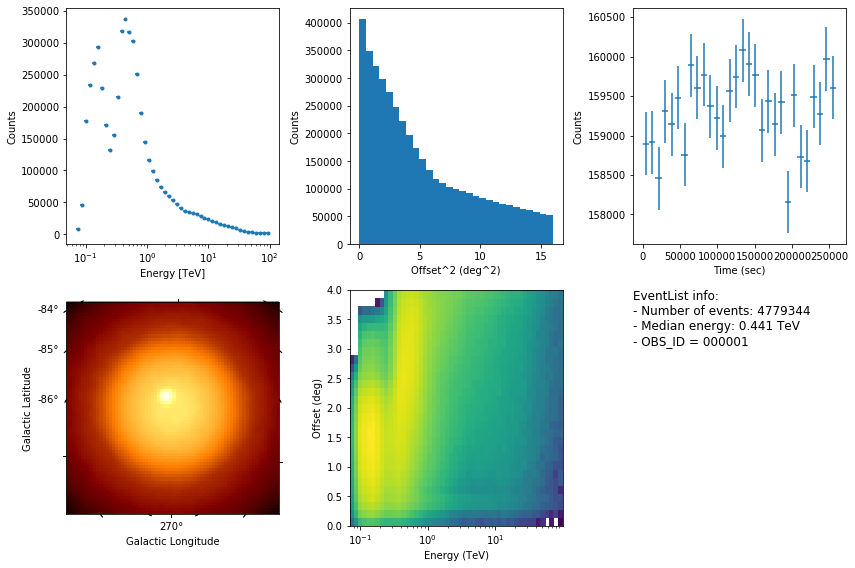

In [19]:
events.peek()

In [20]:
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(d.galactic.l.deg, d.galactic.b.deg), npix=(250, 200), binsz=0.02, coordsys="GAL", axes=[axis]
)
geom

WcsGeom

	axes       : lon, lat, energy
	shape      : (250, 200, 9)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 97.2 deg, -88.0 deg
	width      : 5.0 deg x 4.0 deg

In [21]:
target_position = SkyCoord(d.galactic.l.deg, d.galactic.b.deg, unit="deg", frame="galactic")
on_radius = 0.1 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (250, 200)
	ndim  : 2
	unit  : '' 
	dtype : bool 



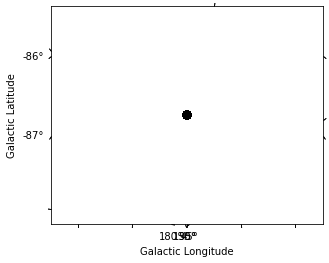

In [22]:
exclusion_mask = geom.to_image().region_mask([on_region], inside=False)
exclusion_mask = WcsNDMap(geom.to_image(), exclusion_mask)
print(exclusion_mask)
exclusion_mask.plot();

CPU times: user 39.9 s, sys: 1.54 s, total: 41.4 s
Wall time: 41.4 s


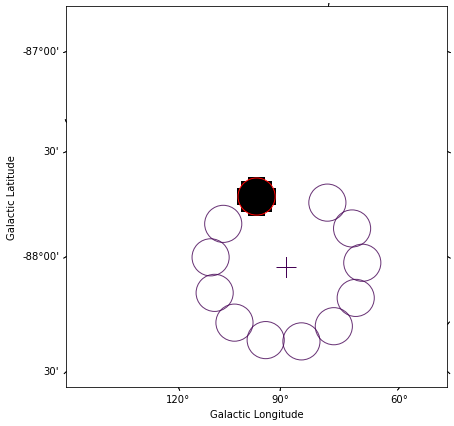

In [23]:
%%time
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    observations=observations,
    on_region=on_region,
    exclusion_mask=exclusion_mask,
)
bkg_estimator.run()
bkg_estimate = bkg_estimator.result
bkg_estimator.plot();

In [24]:
%%time
maker = MapMaker(geom, offset_max="2 deg")
maps = maker.run(observations)
print(maps.keys())

dict_keys(['counts', 'exposure', 'background'])
CPU times: user 6.96 s, sys: 913 ms, total: 7.87 s
Wall time: 8.44 s


In [25]:
# The maps are cubes, with an energy axis.
# Let's also make some images:
images = maker.run_images()

excess = images["counts"].copy()
excess.data -= images["background"].data
images["excess"] = excess

In [26]:
print(np.max(images["counts"].data))

530.0


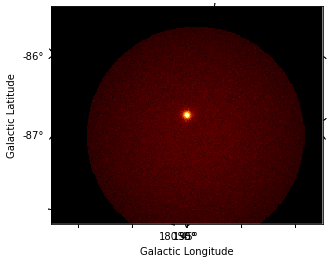

In [27]:
images["counts"].plot();

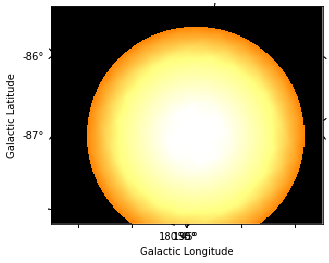

In [28]:
images["background"].plot();

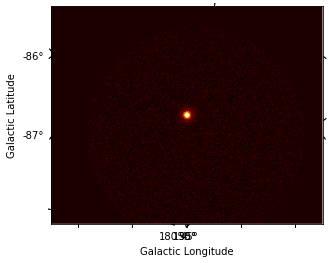

In [29]:
images["excess"].plot();

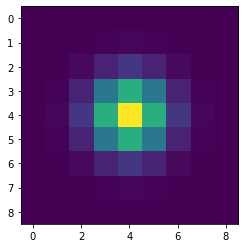

In [30]:
kernel = Gaussian2DKernel(1, mode="oversample").array
plt.imshow(kernel);

In [31]:
%%time
ts_image_estimator = TSMapEstimator()
images_ts = ts_image_estimator.run(images, kernel)
print(images_ts.keys())

dict_keys(['ts', 'sqrt_ts', 'flux', 'flux_err', 'flux_ul', 'niter'])
CPU times: user 434 ms, sys: 44.9 ms, total: 479 ms
Wall time: 4.57 s


In [32]:
sources = find_peaks(images_ts["sqrt_ts"], threshold=8)
sources

value,x,y,ra,dec
,,,deg,deg
float32,int64,int64,float64,float64
110.75,124,100,11.88590,-25.27665


In [33]:
source_pos = SkyCoord(sources["ra"], sources["dec"])
source_pos

<SkyCoord (ICRS): (ra, dec) in deg
    [(11.88589719, -25.27664846)]>

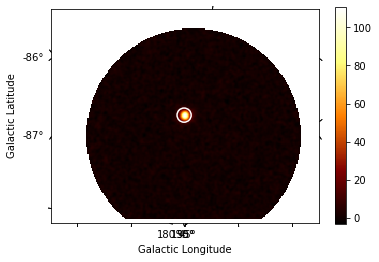

In [34]:
# Plot sources on top of significance sky image
images_ts["sqrt_ts"].plot(add_cbar=True)

plt.gca().scatter(
    source_pos.ra.deg,
    source_pos.dec.deg,
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="white",
    marker="o",
    s=200,
    lw=1.5,
);

In [24]:
%%time
extract = SpectrumExtraction(
    observations=observations, bkg_estimate=bkg_estimate
)
extract.run()
extract.compute_energy_threshold()

CPU times: user 483 ms, sys: 68.2 ms, total: 551 ms
Wall time: 541 ms


In [25]:
%%time
model = models.PowerLaw(
    index=2, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)

for dataset in extract.spectrum_observations:
    dataset.model = model

fit = Fit(extract.spectrum_observations)
result = fit.run()
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 103
	total stat : 621.95

CPU times: user 172 ms, sys: 8.01 ms, total: 180 ms
Wall time: 179 ms


In [26]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
index,2.196e+00,6.534e-03,,nan,nan,False
amplitude,1.917e-12,1.780e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


In [27]:
# Flux points are computed on stacked observation
from gammapy.spectrum import SpectrumDatasetOnOffStacker

stacker = SpectrumDatasetOnOffStacker(extract.spectrum_observations)
stacked_obs = stacker.run()

print(stacked_obs)

SpectrumDatasetOnOff

    Total counts                    : 22353 
    Total predicted counts          : nan
    Total off counts                : 77850.00

    Effective area min              : 8.80e+05 cm2
    Effective area max              : 5.45e+10 cm2

    Livetime                        : 2.54e+05 s

    Number of total bins            : 72 
    Number of fit bins              : 72 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0

    Acceptance mean:                : 1.0



In [28]:
e_edges = np.logspace(0, 1.5, 5) * u.TeV

stacked_obs.model = model

fpe = FluxPointsEstimator(datasets=[dataset], e_edges=e_edges)
flux_points = fpe.run()
flux_points.table_formatted


e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,loglike,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],dloglike_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.565,1.000,2.448,7.172e-13,1.054e-12,1.575e-12,1.756e-12,1.217,13.265,0.023,3359,0.023,0.023,1.263,93.139,8674.820,0.200 .. 5.000,4462.005408689562 .. 10179.923568875362,8.726e-13,9.059e-13,1.638e-14,1.662e-14,1.614e-14
3.831,2.448,5.995,1.004e-13,3.612e-13,1.321e-12,1.474e-12,1.029,10.503,0.026,1680,0.027,0.026,1.082,74.102,5491.040,0.200 .. 5.000,2315.7989438916384 .. 7248.277179852703,1.033e-13,1.087e-13,2.631e-15,2.670e-15,2.593e-15
8.799,5.995,12.915,1.618e-14,1.131e-13,9.622e-13,1.252e-12,0.858,3.420,0.032,803,0.032,0.032,0.924,48.497,2352.007,0.200 .. 5.000,877.3218558149133 .. 4562.1728646090105,1.388e-14,1.495e-14,5.204e-16,5.247e-16,5.161e-16
20.209,12.915,31.623,2.606e-15,4.944e-14,9.543e-13,1.064e-12,0.740,11.562,0.038,445,0.039,0.038,0.820,33.098,1095.486,0.200 .. 5.000,384.71603443134734 .. 3065.3226442813275,1.930e-15,2.136e-15,1.002e-16,1.018e-16,9.869e-17


In [29]:
model.parameters.covariance = result.parameters.covariance
flux_points_dataset = FluxPointsDataset(data=flux_points, model=model)

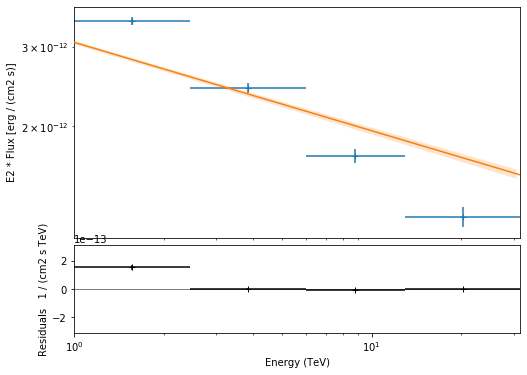

In [30]:
plt.figure(figsize=(8, 6))
flux_points_dataset.peek();